# Analytics seconda prova Giugno

Il compito consiste nell’analizzare il dataset Telekom  ed ottenere un modello predittivo in grado di individuare la classe di appartenenza (STATUS, binaria). La legenda è nel file txt  allegato.

Le fasi dell’analisi consistono in:

1) Preprocessing dei dati (trasformazioni, ricodifiche, selezione) imputare le variabili che hanno missing

2) Individuazione del modello ottimale, scegliendo tra quelli conosciuti (Alberi, gradient boosting, foreste random, logistico, reti neurali, ….)

3) Risultati di valutazione(a scelta tra hold-out o cross-validation): matrici di confusione e AUC nel training e nel test (o cross-validation), curva ROC.

4) Provare a bilanciare la target e verificare la differenza nei risultati 

5) Valutare sinteticamente (10 righe) i risultati ottenuti

**I risultati e i commenti devono essere messi in un file .doc di cui dovete effettuare l'upload**

Importo le librerie di alto livello di cui avrò bisogno

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer,LabelEncoder,OneHotEncoder,StandardScaler
from sklearn.cross_validation import cross_val_score,cross_val_predict,train_test_split
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,roc_curve,classification_report
from keras import Sequential
from keras.utils import np_utils
from keras.layers import Activation,BatchNormalization,Dropout,Dense
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from keras.optimizers import Adam
%matplotlib inline

importo il dataset

In [14]:
dataset=pd.read_csv('./telekom.csv',delimiter=',')

In [15]:
#guardo le prime righe del dataset e rimuovo la variabile ID inutile ai fini della classificazione.
dataset=dataset.drop('ID',axis=1)
dataset.head()

,status,piano_tariff,metodo_pagamento,sesso,etacl,zona_attivaz,canale_attivaz,vas1,vas2,q01_out_ch_peak,...,q01_in_dur_tot,q01_ch_sms,q09_out_ch_peak,q09_out_dur_peak,q09_out_val_peak,q09_out_dur_offpeak,q09_out_val_offpeak,q09_in_ch_tot,q09_in_dur_tot,q09_ch_sms
0,0,8,3,3,30.75,3,5,1,1,45,...,2162,0,78,5190,34.6450,0,0.0,123,10715,0
1,0,8,1,3,20.78,2,5,1,1,0,...,0,0,11,719,4.8191,0,0.0,31,3115,1
2,0,7,3,3,19.80,1,5,1,1,0,...,0,0,50,2665,14.1168,0,0.0,170,14807,0
3,0,8,2,3,21.67,1,9,1,1,0,...,0,0,65,7216,43.6824,0,0.0,25,3334,0
4,0,8,2,1,24.75,1,5,1,1,0,...,0,0,0,0,0.0000,0,0.0,0,0,0


**Vediamo se ci sono variabili con Na's**

In [16]:
print(dataset.isnull().values.any())
print(dataset.columns[dataset.isnull().any()].tolist())

False
[]


In [17]:
len(dataset.columns)

25

Leggendo la descrizione delle variabili emerge che:
- non ci sono variabili qualitative sul quale applicare Label Encoder
- Le variabili (features) categoriche sul quale applicare l'encoding sono:
        + piano_tariff
        + metodo_pagamento
        + sesso
        + zona_attivaz
        + canale_attivaz
        + vas1
        + vas2
- Le restanti variabili sono numeriche 
- La variabile 'status' è la nostra **variabile risposta $y$**

***encoding***

In [18]:
dataset=pd.get_dummies(dataset,columns=['piano_tariff','metodo_pagamento','sesso'
                                        ,'zona_attivaz','canale_attivaz','vas1','vas2'])

In [19]:
len(dataset.columns)

45

Ora divido il dataset in $X$ ed $y$

In [21]:
X=dataset.drop('status',axis=1).values
y=dataset['status'].values

In [24]:
#provo a selezionare con SelectKbest, le 20 variabili migliori tramite il calcolo del chi2
#X_new = SelectKBest(chi2, k=20).fit_transform(X, y)

A questo punto utilizzo la tecnica dell'HOLD OUT per dividere il dataset in Train e Test.

In [39]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3)

Ho deciso di utilizzare tre modelli e confrontarli tra loro:
- Random Forest classifier
- Gradient Boosting classifier
    - eventualmente faccio il tuning dei parametri con Grid Search
- Neural network


In [40]:
from sklearn.preprocessing import StandardScaler
#scale the X coloumns
sc_X = StandardScaler()
#for the training set we need to fit it, then scale it
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

**RANDOM FOREST CLASSIFIER**

Accuracy: 0.953373768006

Confusion matrix:
[[1590   81]
 [  42  925]]

auc: 0.989547396991


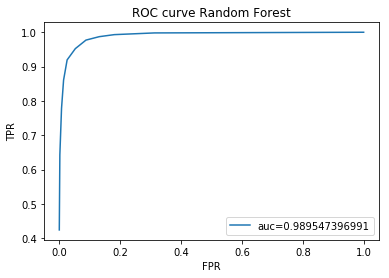

In [42]:

RFC=RandomForestClassifier()
RFC.fit(X_train,y_train)
y_pred=RFC.predict(X_test)

#calcolo accuracy
accuracy=accuracy_score(y_pred,y_test)
print('Accuracy: '+str(accuracy))
print()
print('Confusion matrix:')
cm=confusion_matrix(y_pred,y_test)
print(cm)

y_pred_proba = RFC.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
print()
print("auc: "+str(auc))
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve Random Forest')
plt.legend(loc=4)
plt.show()

RF_out=[accuracy,auc]

**GRADIENT BOOSTING**

Accuracy: 0.974981046247

Confusion matrix:
[[1593   27]
 [  39  979]]

auc: 0.989547396991


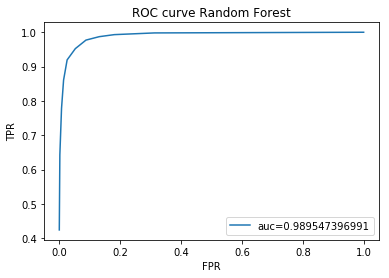

In [43]:
GB=GradientBoostingClassifier()
GB.fit(X_train,y_train)
y_pred=GB.predict(X_test)

#calcolo accuracy
accuracy=accuracy_score(y_pred,y_test)
print('Accuracy: '+str(accuracy))
print()
print('Confusion matrix:')
cm=confusion_matrix(y_pred,y_test)
print(cm)

y_pred_proba = RFC.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
print()
print("auc: "+str(auc))
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve Random Forest')
plt.legend(loc=4)
plt.show()

GB_out=[accuracy,auc]

**RETE NEURALE**

In [48]:
model = Sequential()
model.add(Dense(8,input_dim=X_train.shape[1],activation='relu',kernel_initializer='normal'))
model.add(Dropout(0.3))
model.add(Dense(8,activation='relu',kernel_initializer='normal'))
model.add(Dropout(0.5))
model.add(Dense(8,activation='relu',kernel_initializer='normal'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

adam=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

model.fit(X_train, y_train,epochs=200,batch_size=64)



y_pred=model.predict(X_test)
y_pred1=[]
for i in range(0,len(y_pred)):
    y_pred1.append(np.round(y_pred[i][0]))
y_pred=np.array(y_pred1,dtype=np.int64)
accuracy=accuracy_score(y_pred,y_test)
print('accuracy: %s'%accuracy)
print()
print('confusion matrix: ')
cm=confusion_matrix(y_pred,y_test)
print(cm)

nn_out=[accuracy,'NA']

Epoch 1/200
6154/6154 [==============================] - 1s 103us/step - loss: 0.6587 - acc: 0.6176
Epoch 2/200
6154/6154 [==============================] - 0s 19us/step - loss: 0.4864 - acc: 0.6280
Epoch 3/200
6154/6154 [==============================] - 0s 19us/step - loss: 0.3918 - acc: 0.8694
Epoch 4/200
6154/6154 [==============================] - 0s 19us/step - loss: 0.3553 - acc: 0.9118
Epoch 5/200
6154/6154 [==============================] - 0s 19us/step - loss: 0.3333 - acc: 0.9054
Epoch 6/200
6154/6154 [==============================] - 0s 19us/step - loss: 0.3119 - acc: 0.9204
Epoch 7/200
6154/6154 [==============================] - 0s 19us/step - loss: 0.2849 - acc: 0.9251
Epoch 8/200
6154/6154 [==============================] - 0s 19us/step - loss: 0.2699 - acc: 0.9279
Epoch 9/200
6154/6154 [==============================] - 0s 19us/step - loss: 0.2635 - acc: 0.9285
Epoch 10/200
6154/6154 [==============================] - 0s 19us/step - loss: 0.2493 - acc: 0.9363
Epoch 11

6154/6154 [==============================] - 0s 27us/step - loss: 0.1325 - acc: 0.9579
Epoch 84/200
6154/6154 [==============================] - 0s 19us/step - loss: 0.1294 - acc: 0.9602
Epoch 85/200
6154/6154 [==============================] - 0s 20us/step - loss: 0.1301 - acc: 0.9600
Epoch 86/200
6154/6154 [==============================] - 0s 19us/step - loss: 0.1250 - acc: 0.9594
Epoch 87/200
6154/6154 [==============================] - 0s 23us/step - loss: 0.1266 - acc: 0.9602
Epoch 88/200
6154/6154 [==============================] - 0s 21us/step - loss: 0.1231 - acc: 0.9623
Epoch 89/200
6154/6154 [==============================] - 0s 20us/step - loss: 0.1379 - acc: 0.9558
Epoch 90/200
6154/6154 [==============================] - 0s 19us/step - loss: 0.1303 - acc: 0.9594
Epoch 91/200
6154/6154 [==============================] - 0s 20us/step - loss: 0.1276 - acc: 0.9599
Epoch 92/200
6154/6154 [==============================] - 0s 19us/step - loss: 0.1226 - acc: 0.9615
Epoch 93/200


6154/6154 [==============================] - 0s 25us/step - loss: 0.1246 - acc: 0.9604
Epoch 165/200
6154/6154 [==============================] - 0s 22us/step - loss: 0.1138 - acc: 0.9656
Epoch 166/200
6154/6154 [==============================] - 0s 24us/step - loss: 0.1133 - acc: 0.9664
Epoch 167/200
6154/6154 [==============================] - 0s 26us/step - loss: 0.1129 - acc: 0.9659
Epoch 168/200
6154/6154 [==============================] - 0s 25us/step - loss: 0.1330 - acc: 0.9602
Epoch 169/200
6154/6154 [==============================] - 0s 27us/step - loss: 0.1227 - acc: 0.9608
Epoch 170/200
6154/6154 [==============================] - 0s 24us/step - loss: 0.1160 - acc: 0.9641
Epoch 171/200
6154/6154 [==============================] - 0s 29us/step - loss: 0.1229 - acc: 0.9625
Epoch 172/200
6154/6154 [==============================] - 0s 25us/step - loss: 0.1164 - acc: 0.9649
Epoch 173/200
6154/6154 [==============================] - 0s 20us/step - loss: 0.1233 - acc: 0.9626
Epoc

In [49]:
compare=pd.DataFrame(list(zip(RF_out,GB_out,nn_out,)),
                     index=pd.Series(['accuracy','auc'], name='metrics'),
              columns=['Random Forest','Gradient boosting','Neural network'])


In [50]:
compare

,Random Forest,Gradient boosting,Neural network
metrics,,,
accuracy,0.953374,0.974981,0.988628
auc,0.989547,0.989547,NA


**Ora provo a fare il balancing del train e vedere se migliora la prediction**

In [51]:
from imblearn.over_sampling import SMOTE
from sklearn.externals.joblib.parallel import _backend

sm = SMOTE(random_state=0, ratio = 1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)

/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


**RANDOM FOREST**

Accuracy: 0.941243366187

Confusion matrix:
[[1553   76]
 [  79  930]]

auc: 0.98604390812


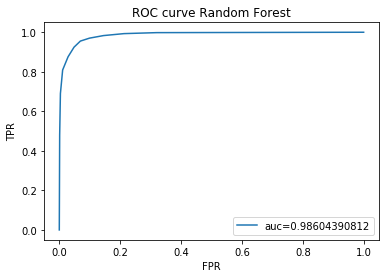

In [55]:
RFC=RandomForestClassifier()
RFC.fit(X_train,y_train)
y_pred=RFC.predict(X_test)

#calcolo accuracy
accuracy=accuracy_score(y_pred,y_test)
print('Accuracy: '+str(accuracy))
print()
print('Confusion matrix:')
cm=confusion_matrix(y_pred,y_test)
print(cm)

y_pred_proba = RFC.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
print()
print("auc: "+str(auc))
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve Random Forest')
plt.legend(loc=4)
plt.show()

RF_out_balance=[accuracy,auc]

**GRADIENT BOOSTING**

Accuracy: 0.971569370735

Confusion matrix:
[[1573   16]
 [  59  990]]

auc: 0.98604390812


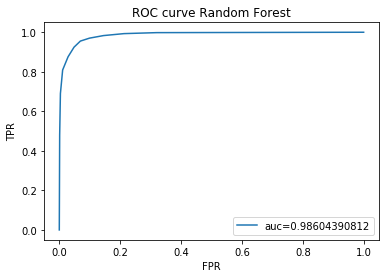

In [56]:
GB=GradientBoostingClassifier()
GB.fit(X_train,y_train)
y_pred=GB.predict(X_test)

#calcolo accuracy
accuracy=accuracy_score(y_pred,y_test)
print('Accuracy: '+str(accuracy))
print()
print('Confusion matrix:')
cm=confusion_matrix(y_pred,y_test)
print(cm)

y_pred_proba = RFC.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
print()
print("auc: "+str(auc))
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve Random Forest')
plt.legend(loc=4)
plt.show()

GB_out_balance=[accuracy,auc]

**RETE NEURALE**

In [57]:
model = Sequential()
model.add(Dense(8,input_dim=X_train.shape[1],activation='relu',kernel_initializer='normal'))
model.add(Dropout(0.3))
model.add(Dense(8,activation='relu',kernel_initializer='normal'))
model.add(Dropout(0.5))
model.add(Dense(8,activation='relu',kernel_initializer='normal'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

adam=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

model.fit(X_train, y_train,epochs=200,batch_size=64)



y_pred=model.predict(X_test)
y_pred1=[]
for i in range(0,len(y_pred)):
    y_pred1.append(np.round(y_pred[i][0]))
y_pred=np.array(y_pred1,dtype=np.int64)
accuracy=accuracy_score(y_pred,y_test)
print('accuracy: %s'%accuracy)
print()
print('confusion matrix: ')
cm=confusion_matrix(y_pred,y_test)
print(cm)

nn_out_balance=[accuracy,'NA']

Epoch 1/200
7618/7618 [==============================] - 1s 100us/step - loss: 0.6568 - acc: 0.5692
Epoch 2/200
7618/7618 [==============================] - 0s 21us/step - loss: 0.4933 - acc: 0.8670
Epoch 3/200
7618/7618 [==============================] - 0s 22us/step - loss: 0.3844 - acc: 0.9014
Epoch 4/200
7618/7618 [==============================] - 0s 22us/step - loss: 0.3307 - acc: 0.9076
Epoch 5/200
7618/7618 [==============================] - 0s 21us/step - loss: 0.2911 - acc: 0.9086
Epoch 6/200
7618/7618 [==============================] - 0s 20us/step - loss: 0.2717 - acc: 0.9233
Epoch 7/200
7618/7618 [==============================] - 0s 19us/step - loss: 0.2686 - acc: 0.9197
Epoch 8/200
7618/7618 [==============================] - 0s 19us/step - loss: 0.2458 - acc: 0.9252
Epoch 9/200
7618/7618 [==============================] - 0s 19us/step - loss: 0.2345 - acc: 0.9282
Epoch 10/200
7618/7618 [==============================] - 0s 19us/step - loss: 0.2410 - acc: 0.9268
Epoch 11

7618/7618 [==============================] - 0s 20us/step - loss: 0.1548 - acc: 0.9517
Epoch 84/200
7618/7618 [==============================] - 0s 20us/step - loss: 0.1670 - acc: 0.9468
Epoch 85/200
7618/7618 [==============================] - 0s 20us/step - loss: 0.1568 - acc: 0.9506
Epoch 86/200
7618/7618 [==============================] - 0s 20us/step - loss: 0.1584 - acc: 0.9497
Epoch 87/200
7618/7618 [==============================] - 0s 20us/step - loss: 0.1599 - acc: 0.9509
Epoch 88/200
7618/7618 [==============================] - 0s 20us/step - loss: 0.1665 - acc: 0.9484
Epoch 89/200
7618/7618 [==============================] - 0s 20us/step - loss: 0.1544 - acc: 0.9548
Epoch 90/200
7618/7618 [==============================] - 0s 20us/step - loss: 0.1609 - acc: 0.9492
Epoch 91/200
7618/7618 [==============================] - 0s 20us/step - loss: 0.1499 - acc: 0.9506
Epoch 92/200
7618/7618 [==============================] - 0s 19us/step - loss: 0.1573 - acc: 0.9508
Epoch 93/200


7618/7618 [==============================] - 0s 20us/step - loss: 0.1544 - acc: 0.9523
Epoch 165/200
7618/7618 [==============================] - 0s 20us/step - loss: 0.1588 - acc: 0.9514
Epoch 166/200
7618/7618 [==============================] - 0s 20us/step - loss: 0.1558 - acc: 0.9499
Epoch 167/200
7618/7618 [==============================] - 0s 20us/step - loss: 0.1588 - acc: 0.9493
Epoch 168/200
7618/7618 [==============================] - 0s 20us/step - loss: 0.1512 - acc: 0.9513
Epoch 169/200
7618/7618 [==============================] - 0s 20us/step - loss: 0.1580 - acc: 0.9500
Epoch 170/200
7618/7618 [==============================] - 0s 20us/step - loss: 0.1421 - acc: 0.9555
Epoch 171/200
7618/7618 [==============================] - 0s 22us/step - loss: 0.1568 - acc: 0.9508
Epoch 172/200
7618/7618 [==============================] - 0s 22us/step - loss: 0.1588 - acc: 0.9504
Epoch 173/200
7618/7618 [==============================] - 0s 21us/step - loss: 0.1479 - acc: 0.9517
Epoc

In [58]:
compare=pd.DataFrame(list(zip(RF_out,GB_out,nn_out,RF_out_balance,GB_out_balance,nn_out_balance)),
                     index=pd.Series(['accuracy','auc'], name='metrics'),
              columns=['Random Forest','Gradient boosting','Neural network','Random Forest balanced','Gradient boosting balanced','Neural network balanced'])


In [59]:
compare

,Random Forest,Gradient boosting,Neural network,Random Forest balanced,Gradient boosting balanced,Neural network balanced
metrics,,,,,,
accuracy,0.950341,0.971569,0.97953,0.941243,0.971569,0.985595
auc,0.986528,0.986528,NA,0.986044,0.986044,NA


**CROSS VALIDATION**

In [67]:
from sklearn.cross_validation import cross_val_score
RFC = RandomForestClassifier()
scores = cross_val_score(RFC, X, y, cv=5)
# stampe
print('\n Stampa dei risultati ')
print('Tree k-fold CV-error: %f' % scores.mean())

# k-fold cross-validation --> stima Y
predicted = cross_val_predict(RFC, X, y, cv=5)

print("Confusion matrix:\n%s" % confusion_matrix(y, predicted))


 Stampa dei risultati 
Tree k-fold CV-error: 0.937101
Confusion matrix:
[[5233  208]
 [ 294 3057]]


In [66]:
from sklearn.cross_validation import cross_val_score
RFC = GradientBoostingClassifier()
scores = cross_val_score(RFC, X, y, cv=5)
# stampe
print('\n Stampa dei risultati ')
print('Tree k-fold CV-error: %f' % scores.mean())

# k-fold cross-validation --> stima Y
predicted = cross_val_predict(RFC, X, y, cv=5)

print("Confusion matrix:\n%s" % confusion_matrix(y, predicted))


 Stampa dei risultati 
Tree k-fold CV-error: 0.970996
Confusion matrix:
[[5271  170]
 [  85 3266]]


**COMMENTI**
... brevi cenni sull'analisi fatta..

Gli algoritmi applicati sono essenzaialmente tre:
+ Random Forest
+ Gradien boosting
+ rete neurale

Una volta fatto il fitting dei dati mediante i tre algoritmi abbiamo riportato in tabella per ognuno di essi quelle che sono le metriche di confronto più comuni:
- Accuracy
- Roc curve e auc (area under the curve)

I tre algoritmi sono stati provati su:
+ dataset pulito, splittato in train e test (HOLD OUT)
+ dataset pulito, splittato in train e test (HOLD OUT) con train bilanciato
+ dataset pulito, non splittato in train e test, ma utilizzando la cross validation

Ho scelto di comparare la "semplicità" e la maggior interpretabilità dei "Decision trees" con la complessità delle reti neurali, spesso definite come "Black box" per il procedimento non limpido che si cela dietro la classificazione.

Sicuramente sia il *Random forest* che il *Gradient boosting* sono più performanti rispetto ai  classici decision trees in quanto uno step fondamentale di questi algoritmi è il **Bagging**:
- cioè vengono presi piu samples di Bootstrap dal dataset (train) e vengono creati degli alberi e quindi fatto il fit per ognuno di essi e poi fatta la media delle prediction degli  "M1,...,Mb" modelli.

Bootstrap + aggregation $\rightarrow$ Bagging

Nonostante le elevate performance di entrambi i modelli, la rete neurale sembra comunque fare una predizione più accurata.